In [1]:
import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_colwidth', 500)
import warnings
import time
warnings.filterwarnings("ignore", category=FutureWarning)

import geopandas as gpd
import shapely
import numpy as np
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator

import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

import nomad.io.base as loader
import nomad.stop_detection.utils as utils
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
#import nomad.stop_detection.ta_dbscan as TADBSCAN
import nomad.stop_detection.dbscan as TADBSCAN
import nomad.stop_detection.grid_based as GRID_BASED # for oracle visits
import nomad.stop_detection.postprocessing as pp

import nomad.visit_attribution as visits
import nomad.filters as filters
import nomad.city_gen as cg

from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, precision_recall_f1_from_minutes
import pdb

In [23]:
import nomad.city_gen as cg
city = cg.load('../garden-city.pkl')

def plot_metrics_boxplots(df, metrics,
                          algo_order=None, colors=None,
                          figsize=(24, 5.5), save_path=None):
    # --- normalise inputs -------------------------------------------------
    if algo_order is None:
        # preserve appearance order in the DataFrame
        algo_order = df.algorithm.drop_duplicates().tolist()

    if colors is None:
        cmap = plt.colormaps.get_cmap('tab10')
        colors = {a: cmap(i % cmap.N) for i, a in enumerate(algo_order)}
    else:
        # fill in any missing algorithm colour with the next Tab10 entry
        cmap = plt.colormaps.get_cmap('tab10')
        for i, a in enumerate(algo_order):
            colors.setdefault(a, cmap(i % cmap.N))

    # --- figure -----------------------------------------------------------
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize, sharey=False)

    if len(metrics) == 1:          # when only one metric is passed
        axes = [axes]

    for ax, metric in zip(axes, metrics):
        ax.set_facecolor('#EAEAF2')

        # list of series, one per algorithm
        data = [df.loc[df.algorithm == a, metric].dropna() for a in algo_order]

        bp = ax.boxplot(data,
                        positions=range(len(algo_order)),
                        patch_artist=True,
                        widths=0.4,
                        whis=(5, 95),
                        showfliers=False,
                        medianprops={'color': 'black', 'linewidth': 0.6})

        for box, alg in zip(bp['boxes'], algo_order):
            box.set_facecolor(colors[alg])

        ax.grid(axis='y', color='darkgray', linestyle='--', linewidth=0.8)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.set_title(metric.replace('_', ' ').title(), fontsize=16)
        ax.set_xticks([])

    # legend
    handles = [plt.matplotlib.patches.Patch(color=colors[a], label=a)
               for a in algo_order]
    fig.legend(handles, algo_order,
               loc='lower center',
               ncol=len(algo_order),
               bbox_to_anchor=(0.5, -0.015),
               fontsize=15)

    plt.subplots_adjust(bottom=0.1, top=0.95)

    if save_path:
        fig.savefig(f'{save_path}.png', dpi=300)
        fig.savefig(f'{save_path}.svg')

    plt.show()

def classify_building_size_from_id(building_id):
    building = city.buildings.get(building_id)
    n_blocks = len(building.blocks)
    if n_blocks == 1:
        return 'small'
    elif 2 <= n_blocks <= 3:
        return 'medium'
    else:
        return 'big'

def classify_building_type_from_id(building_id):
    building = city.buildings.get(building_id)
    return building.building_type

def classify_dwell(duration):
    if duration < 60:
        return 'low'
    elif 60 <= duration <= 180:
        return 'mid'
    else:
        return 'high'

In [3]:
traj_cols = {'user_id':'uid', 'x':'x', 'y':'y', 'timestamp':'timestamp'}
poi_table = gpd.read_file('../garden_city.gpkg')

poi_table = poi_table.rename({'type':'building_type'}, axis=1)
poi_table['building_size'] = poi_table['building_id'].apply(classify_building_size_from_id)

diaries_df = loader.from_file("../../nomad/data/diaries", format="parquet", **traj_cols)
diaries_df = diaries_df.rename({'location':'building_id'}, axis=1)
diaries_df = diaries_df.merge(poi_table[['building_id', 'building_size', 'building_type']], on='building_id', how='left')

diaries_df.loc[~diaries_df.building_id.isna(),'dwell_length'] = diaries_df.loc[~diaries_df.building_id.isna(),'duration'].apply(classify_dwell)
diaries_df['building_id'] = diaries_df['building_id']
sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", **traj_cols)

## Analyze completeness

In [4]:
completeness_df = filters.q_stats(sparse_df, traj_cols=traj_cols)

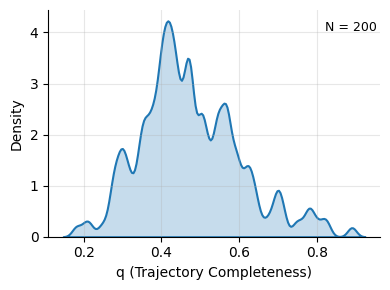

In [5]:
plt.figure(figsize=(4,3))
ax = sns.kdeplot(
    data=completeness_df,
    x="q_stat",
    fill=True,
    linewidth=1.5,
    bw_adjust=0.25
)

# cosmetics
ax.set_xlabel("q (Trajectory Completeness)")
ax.set_ylabel("Density")
ax.grid(True, alpha=0.3)
sns.despine(top=True, right=True)

# annotation (top-right corner in axes coords)
ax.text(
    0.99, 0.95,
    f"N = {len(completeness_df)}",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=9
)

plt.tight_layout()
plt.savefig("q_stat_density.svg", format="svg", bbox_inches="tight")
plt.savefig("q_stat_density.png", format="svg", bbox_inches="tight")
plt.show()

## Execution for all users

In [6]:
## TRANSFORMATION FUNCTIONS
# Use this for steps that should pass a generic DataFrame through
def no_op_df(data, **kwargs):
    return data

# Use this for steps that should pass the 'stops' DataFrame through
def no_op_stops(stops, **kwargs):
    return stops

# Pre-processing snippets
def prejoin_oracle_map(data, diary, **kwargs):
    location = visits.oracle_map(data, diary, timestamp='timestamp', location_id='building_id')
    return data.join(location)

# Post-processing snippets
summarize_stops_with_loc = partial(utils.summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols=['building_id'], complete_output=True)

def postjoin_poly_map(data, **kwargs):
    # This is a post-labeling step, before stop creation
    location = visits.point_in_polygon(data=data, poi_table=poi_table, method='majority', data_crs='EPSG:3857',
                                       max_distance=12, cluster_label='cluster', location_id='building_id', x='x', y='y')
    return data.join(location)

# Special fix/adjustment snippets
def rem_overlaps_hdbscan(stops, data_with_clusters, params, **kwargs):
    if pp.invalid_stops(stops):
        # The 'pred' data for remove_overlaps is the data with clusters and POI locations joined
        return pp.remove_overlaps(data_with_clusters, **params, dur_min=5, traj_cols=traj_cols, method='cluster', location_id='building_id')
    return stops

def pad_oracle_stops(stops, **kwargs):
    return utils.pad_short_stops(stops, pad=5, dur_min=0, start_timestamp='start_timestamp')

def pad_oracle_stops_long(stops, **kwargs):
    return utils.pad_short_stops(stops, pad=15, dur_min=4, start_timestamp='start_timestamp')

# Each row defines the unique workflow for one algorithm
algo_params = pd.DataFrame([
    {
        'algo': 'ta-hdbscan',
        'func': HDBSCAN.hdbscan_labels,
        'params': {'time_thresh': 240, 'min_pts': 3, 'min_cluster_size': 1, 'include_border_points': True},
        'pre_process_func': no_op_df,             # Correct: Passes 'data'
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': rem_overlaps_hdbscan,
    },
    {
        'algo': 'oracle',
        'func': GRID_BASED.grid_based_labels,
        'params': {'time_thresh': 600, 'min_pts': 0, 'location_id': 'building_id'},
        'pre_process_func': prejoin_oracle_map,
        'post_labels_func': no_op_df,             # Correct: Passes 'data'
        'special_fix_func': pad_oracle_stops_long,
    },
    {
        'algo': 'tadbscan_coarse',
        'func': TADBSCAN._temporal_dbscan_labels,
        'params': {'time_thresh': 240, 'min_pts': 2, 'dist_thresh': 30},
        'pre_process_func': no_op_df,             # Correct
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': rem_overlaps_hdbscan,           # Correct
    },
    {
        'algo': 'tadbscan_fine',
        'func': TADBSCAN._temporal_dbscan_labels,
        'params': {'time_thresh': 120, 'min_pts': 3, 'dist_thresh': 20},
        'pre_process_func': no_op_df,             # Correct
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': rem_overlaps_hdbscan,           # Correct
    },
    {
        'algo': 'lachesis_coarse',
        'func': LACHESIS._lachesis_labels,
        'params': {'dt_max': 240, 'delta_roam': 40},
        'pre_process_func': no_op_df,             # Correct: Passes 'data'
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': no_op_stops,           # Correct: Passes 'stops'
    },
    {
        'algo': 'lachesis_fine',
        'func': LACHESIS._lachesis_labels,
        'params': {'dt_max': 120, 'delta_roam': 25},
        'pre_process_func': no_op_df,             # Correct
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': no_op_stops,           # Correct
    }
])

## METRICS FUNCTIONS
def compute_all_metrics(stops, truth, poi_table, user, algo):
    """
    Calculate all metrics.  One expensive overlap on *raw* stops for
    error rates, a second (gap-filled) overlap for precision/recall.
    """

    stops_err = stops.fillna({'building_id': 'Street'})
    
    overlaps_err = overlapping_visits(
        left=stops_err,
        right=truth.dropna(),
        match_location=False,
        location_id='building_id'
    )

    # 2) PRF overlaps on raw stops (no gap fill at all)
    #    truth we still label Street so they appear in the join step
    stops_prf  = stops.fillna({'building_id': 'Street'})
    truth_prf  = truth.copy().fillna({'building_id': 'Street'})
    
    overlaps_prf = overlapping_visits(
        left=stops_prf,
        right=truth_prf,
        match_location=False,
        location_id='building_id'
    )

    # subset to *matching* POI rows
    prf_overlaps = overlaps_prf[
        overlaps_prf['building_id_left'] == overlaps_prf['building_id_right']
    ]

    # 3) global PRF from minute‐totals
    total_pred  = stops_prf['duration'].sum()
    total_truth = truth_prf['duration'].sum()
    tp          = prf_overlaps['duration'].sum()
    prf1 = precision_recall_f1_from_minutes(total_pred, total_truth, tp)

    # 4) error metrics
    errors = compute_visitation_errors(
        overlaps=overlaps_err,
        true_visits=truth.dropna(),
        location_id='building_id'
    )

    results = [
        {'metric_category': 'general',
         'category_value': 'all',
         'total_pred':total_pred,
         **prf1, **errors}
    ]

    # 5) per-category PRF + error
    for category in ['building_size', 'building_type', 'dwell_length']:
        for val in truth[category].dropna().unique():
            truth_sub = truth[(truth[category] == val)&(truth['building_id']!='Street')]
            # restrict overlaps to any prediction *overlapping* these truth stops
            if category == 'dwell_length':                       # slice by stop itself
                mask_err = overlaps_err['timestamp_right'].isin(truth_sub['timestamp'])
                mask_prf = overlaps_prf['timestamp_right'].isin(truth_sub['timestamp'])
            else:                                                # slice by building
                mask_err = overlaps_err['building_id_right'].isin(truth_sub['building_id'])
                mask_prf = overlaps_prf['building_id_right'].isin(truth_sub['building_id'])


            ov_err = overlaps_err[mask_err]
            ov_prf = overlaps_prf[mask_prf]
            prf_ov = ov_prf[ov_prf['building_id_left'] == ov_prf['building_id_right']]

            # per-category PRF from minutes in these slices
            tp_cat       = prf_ov['duration'].sum()
            pred_cat     = ov_err['duration'].sum()
            truth_cat    = truth_sub['duration'].sum()
            prf1_cat     = precision_recall_f1_from_minutes(pred_cat, truth_cat, tp_cat)

            # per-category error on the same slice of truth

            err_cat = compute_visitation_errors(
                overlaps=ov_err,
                true_visits=truth_sub,
                location_id='building_id'
            )

            results.append({
                'metric_category': category,
                'category_value':   val,
                **prf1_cat, **err_cat
            })

    # tag with user & algo
    for rec in results:
        rec.update({'user': user, 'algorithm': algo})

    return results

### OPTIMIZED LOOP

In [ ]:
results_list = []

for user in tqdm(diaries_df.uid.unique(), desc='Processing users'):
    for _, row in algo_params.iloc.iterrows():
        
        # PRE
        sparse = sparse_df[sparse_df['uid'] == user].copy()
        truth = diaries_df[diaries_df['uid'] == user].copy()
        processed_sparse = row.pre_process_func(data=sparse, diary=truth)
        
        # ALGORITHM
        start_time = time.time()
        labels = row.func(processed_sparse, **row.params, traj_cols=traj_cols)
        execution_time = time.time() - start_time
        
        # POST
        data_with_clusters = processed_sparse.join(labels)
        data_with_locations = row.post_labels_func(data=data_with_clusters)
        stops = data_with_locations[data_with_locations.cluster != -1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
        stops = row.special_fix_func(stops=stops, data_with_clusters=data_with_locations, params=row.params)

        # METRICS
        metrics = compute_all_metrics(stops, truth, poi_table, user, row.algo)

        # Add execution time to the first metric entry (the 'general' one)
        if metrics:
            metrics[0]['execution_time'] = execution_time
        
        results_list.extend(metrics)

results_df = pd.DataFrame(results_list)

print("Processing Complete!")

In [7]:
try:
    results_df = pd.read_csv("results.csv")
except:
    results_df.to_csv('results.csv', index=False)

In [8]:
general_metrics_df = results_df[results_df['metric_category'] == 'general'].copy()

In [10]:
# BOOTSTRAPPING GROUPBY
agg_keys = ['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']
ua = general_metrics_df.groupby(['user','algorithm'], as_index=False)[agg_keys].median()
users = ua['user'].unique()
output = []
for _ in range(2000):
    draw = np.random.choice(users, size=len(users), replace=True)
    bs = ua[ua.user.isin(draw)]
    output.append(bs.groupby('algorithm', as_index=False)[agg_keys].median())
metrics_bootstrap_df = pd.concat(output, ignore_index=True)

In [ ]:
# # For debugging!!!
# metrics = ['missed_fraction', 'merged_fraction', 'split_fraction', 'precision', 'recall', 'f1']
# plot_metrics_boxplots(metrics_bootstrap_df, metrics, algo_order=None, colors=None, save_path=None)

### Plot boostrapped per-stop metrics for general trajectory

In [24]:
# base colors for coarse versions
shade = lambda c,f=0.6: mcolors.to_hex(tuple(f*x for x in mcolors.to_rgb(c)))
raw = {'oracle':'royalblue','ta-hdbscan':'darkorange','lachesis_coarse':'palevioletred','tadbscan_coarse':'limegreen'}

_base = {k:mcolors.to_hex(mcolors.to_rgb(v)) for k,v in raw.items()}

algo_order = ['oracle','ta-hdbscan','lachesis_coarse','tadbscan_coarse','lachesis_fine', 'tadbscan_fine']
colors = {a:(_base[a] if a in _base else shade(_base[a.split('_')[0]+'_coarse'])) for a in algo_order}

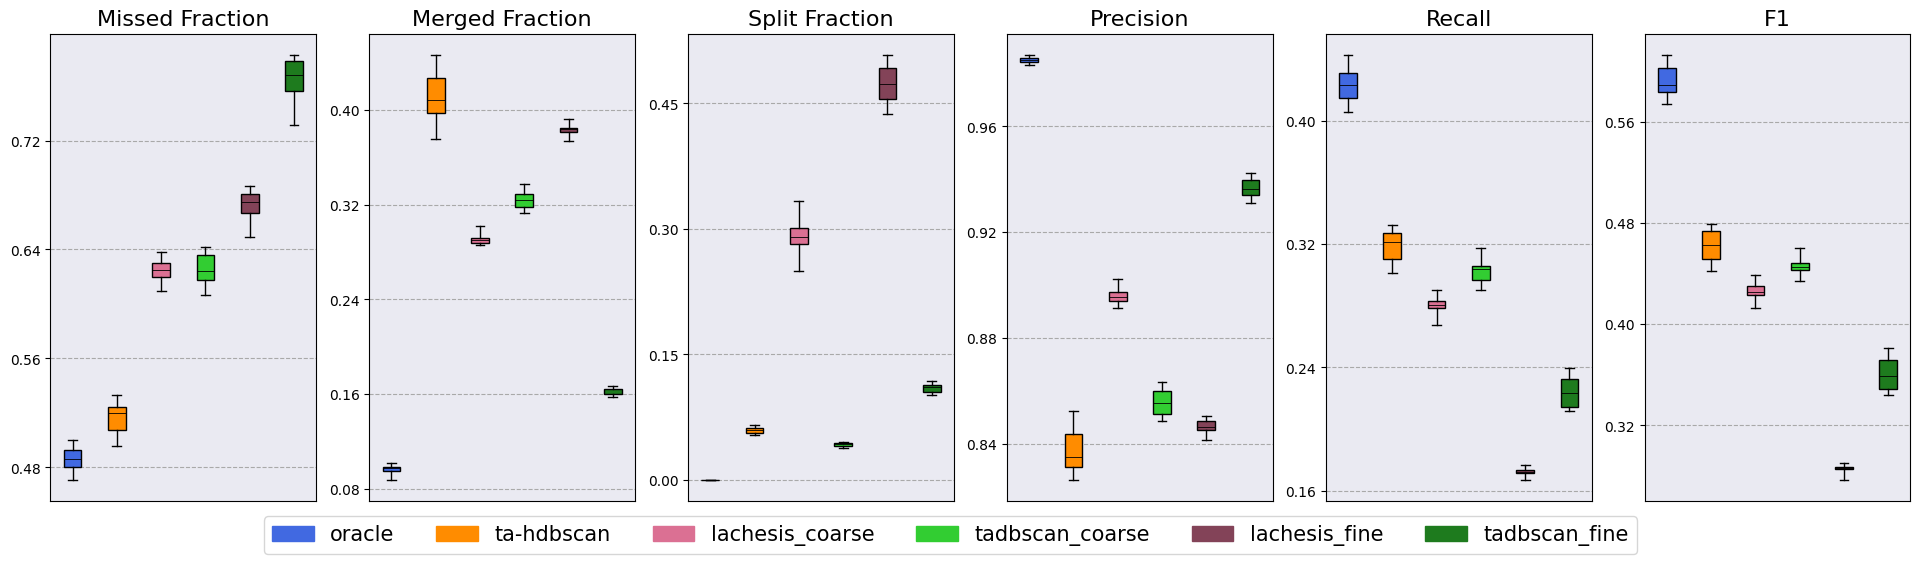

In [25]:
metrics = ['missed_fraction', 'merged_fraction', 'split_fraction', 'precision', 'recall', 'f1']
plot_metrics_boxplots(metrics_bootstrap_df, metrics, algo_order=algo_order, colors=colors, save_path='errors_per_stop')

In [ ]:
# ylabels = {m:f"% {m.split('_')[0]}" for m in ['precision','recall','f1']}
# metrics = ['precision', 'recall', 'f1']
# plot_metrics_boxplots( metrics_bootstrap_df, metrics, algo_order=None, colors=None, save_path='errors_per_stop')

In [ ]:
### Plot pr, rec, f1 per each group in 4 subplots. 

### Plot of F1 scores for each q

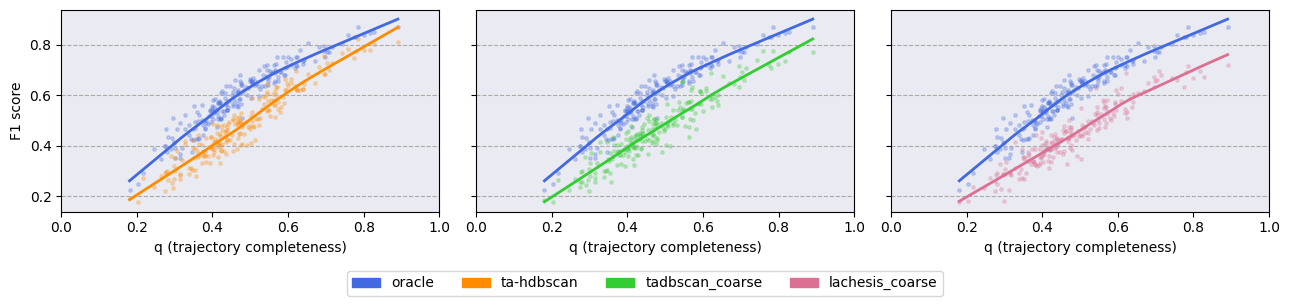

In [15]:
def plot_f1_vs_q(general_df, completeness_df, save_path=None):
    """Three-panel plot: oracle vs hdbscan / tadbscan_coarse / lachesis_coarse."""

    # --- palette & comparison pairs --------------------------------------
    pairs  = [('oracle', 'ta-hdbscan'),
              ('oracle', 'tadbscan_coarse'),
              ('oracle', 'lachesis_coarse')]

    colors = {'oracle': 'royalblue',
              'ta-hdbscan': 'darkorange',
              'tadbscan_coarse': 'limegreen',
              'lachesis_coarse': 'palevioletred'}

    # --- merge: just rename q_stat -> q ----------------------------------
    comp = completeness_df.rename(columns={'q_stat': 'q'})[['uid', 'q']]
    df   = general_df.merge(comp, left_on='user', right_on='uid', how='left')

    # --- figure ----------------------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(13, 2.75), sharey=True)

    for ax, (a1, a2) in zip(axes, pairs):
        ax.set_facecolor('#EAEAF2')            # seaborn-like bg

        for alg in (a1, a2):
            sub = df[df.algorithm == alg].dropna(subset=['q']).sort_values('q')
            if sub.empty:
                continue
            sm  = lowess(sub['f1'], sub['q'], frac=0.6)
            ax.plot(sm[:, 0], sm[:, 1], color=colors[alg], lw=2)
            ax.scatter(sub['q'], sub['f1'], color=colors[alg], s=6, alpha=0.25)

        ax.grid(axis='y', color='darkgray', linestyle='--', lw=0.8)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.set_xlabel("q (trajectory completeness)")
        ax.set_xticks(np.linspace(0, 1, 6))
        ax.tick_params(axis='both', labelsize=10)

    axes[0].set_ylabel("F1 score")

    # --- single legend ---------------------------------------------------
    handles = [plt.matplotlib.patches.Patch(color=colors[a], label=a) for a in colors]
    fig.legend(handles, colors, loc='lower center',
               ncol=len(colors), bbox_to_anchor=(0.5, -0.12))

    plt.tight_layout()

    if save_path:
        fig.savefig(f"{save_path}.png", dpi=300, bbox_inches='tight')
        fig.savefig(f"{save_path}.svg", bbox_inches='tight')

    plt.show()

plot_f1_vs_q(general_metrics_df, completeness_df,
             save_path="f1_vs_q")

### Metrics for each category value

In [19]:
# for each user, algo, and category_value
if 'f1_as_pct_orac' not in results_df:
    oracle_df = results_df.loc[results_df.algorithm == 'oracle', ['user', 'category_value','f1']].rename(columns={'f1':'f1_oracle'})
    results_df = results_df.merge(oracle_df, on=['user','category_value'],  how='left')
    results_df['f1_as_pct_orac'] = 100 * results_df['f1'] / results_df['f1_oracle']

In [26]:
#table_results = results_df.loc[results_df.algorithm.isin(['ta-hdbscan', 'lachesis_coarse','tadbscan_coarse', 'lachesis_fine', 'tadbscan_fine'])]#
table_results = results_df.loc[results_df.algorithm.isin(['ta-hdbscan', 'lachesis_coarse','tadbscan_coarse'])]
table_results = table_results.loc[~table_results.category_value.isin(['all', 'big', 'medium', 'small', 'mid'])]
table_results = table_results.groupby(['metric_category', 'category_value', 'algorithm'], as_index=True)[['f1', 'f1_as_pct_orac']].median().round(2)
table_results.to_csv('results_by_category.csv', index=True)
table_results

f1  f1_as_pct_orac
metric_category category_value algorithm                            
building_type   home           lachesis_coarse  0.50           72.97
                               ta-hdbscan       0.55           81.28
                               tadbscan_coarse  0.53           80.02
                park           lachesis_coarse  0.21           64.83
                               ta-hdbscan       0.24           79.28
                               tadbscan_coarse  0.17           55.97
                retail         lachesis_coarse  0.15           60.14
                               ta-hdbscan       0.15           56.66
                               tadbscan_coarse  0.13           46.15
                work           lachesis_coarse  0.40           80.50
                               ta-hdbscan       0.44           88.42
                               tadbscan_coarse  0.41           81.94
dwell_length    high           lachesis_coarse  0.48           73.91
                               ta-hdbscan       0.53           82.46
                               tadbscan_coarse  0.51           80.57
                low            lachesis_coarse  0.15           58.72
                               ta-hdbscan       0.14           56.46
                               tadbscan_coarse  0.11           43.76